In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as scר
import pandas as pd
from data_gen import *
from visualizations import *
from datasets import *

import squidpy as sq


In [3]:
import pandas as pd
print(pd.__version__)

1.3.5


In [4]:
import cyclum.tuning
import cyclum.models


In [5]:
adata =  read_all_scn_no_obs()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
r_genes = ['Bmal1','Dbp','Nr1d1','Per2','Ciart','Nr1d2','Per1','Tef','Ahsa2','Cct8a','Hsp90aa1','Hsp90ab1','Hsph1']
r_genes2 = ['Dbp','Nr1d1','Per2','Ciart','Nr1d2','Per1','Tef','Ahsa2','Hsp90aa1','Hsp90ab1','Hsph1']
type_genes = ['Agt', 'Itm2a','Tmem212','Hexb','Celf4','Pdgfra','Top2a','Plp1','Opalin','Plin3','Tnr','Col23a1','Vip','Avp','Nms','Cck','C1ql3','Grp','Bdnf']
def pre_processes_for_cyclum(adata_tmp, r_genes,type_genes):
    sc.pp.highly_variable_genes(adata_tmp, n_top_genes=3000)#min_mean=0.0125, max_mean=3, min_disp=0.5)
    for gene in r_genes: # Make sure that the rhytmic and type markers are not filtered out
        adata_tmp.var.highly_variable[gene]=True
    for gene in type_genes:
        adata_tmp.var.highly_variable[gene]=True
    adata_tmp = adata_tmp[:, adata_tmp.var.highly_variable]
    return adata_tmp


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CT' as categorical
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ST' as categorical
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remov

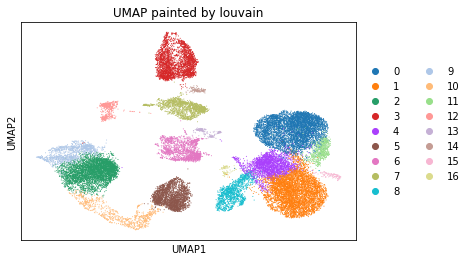

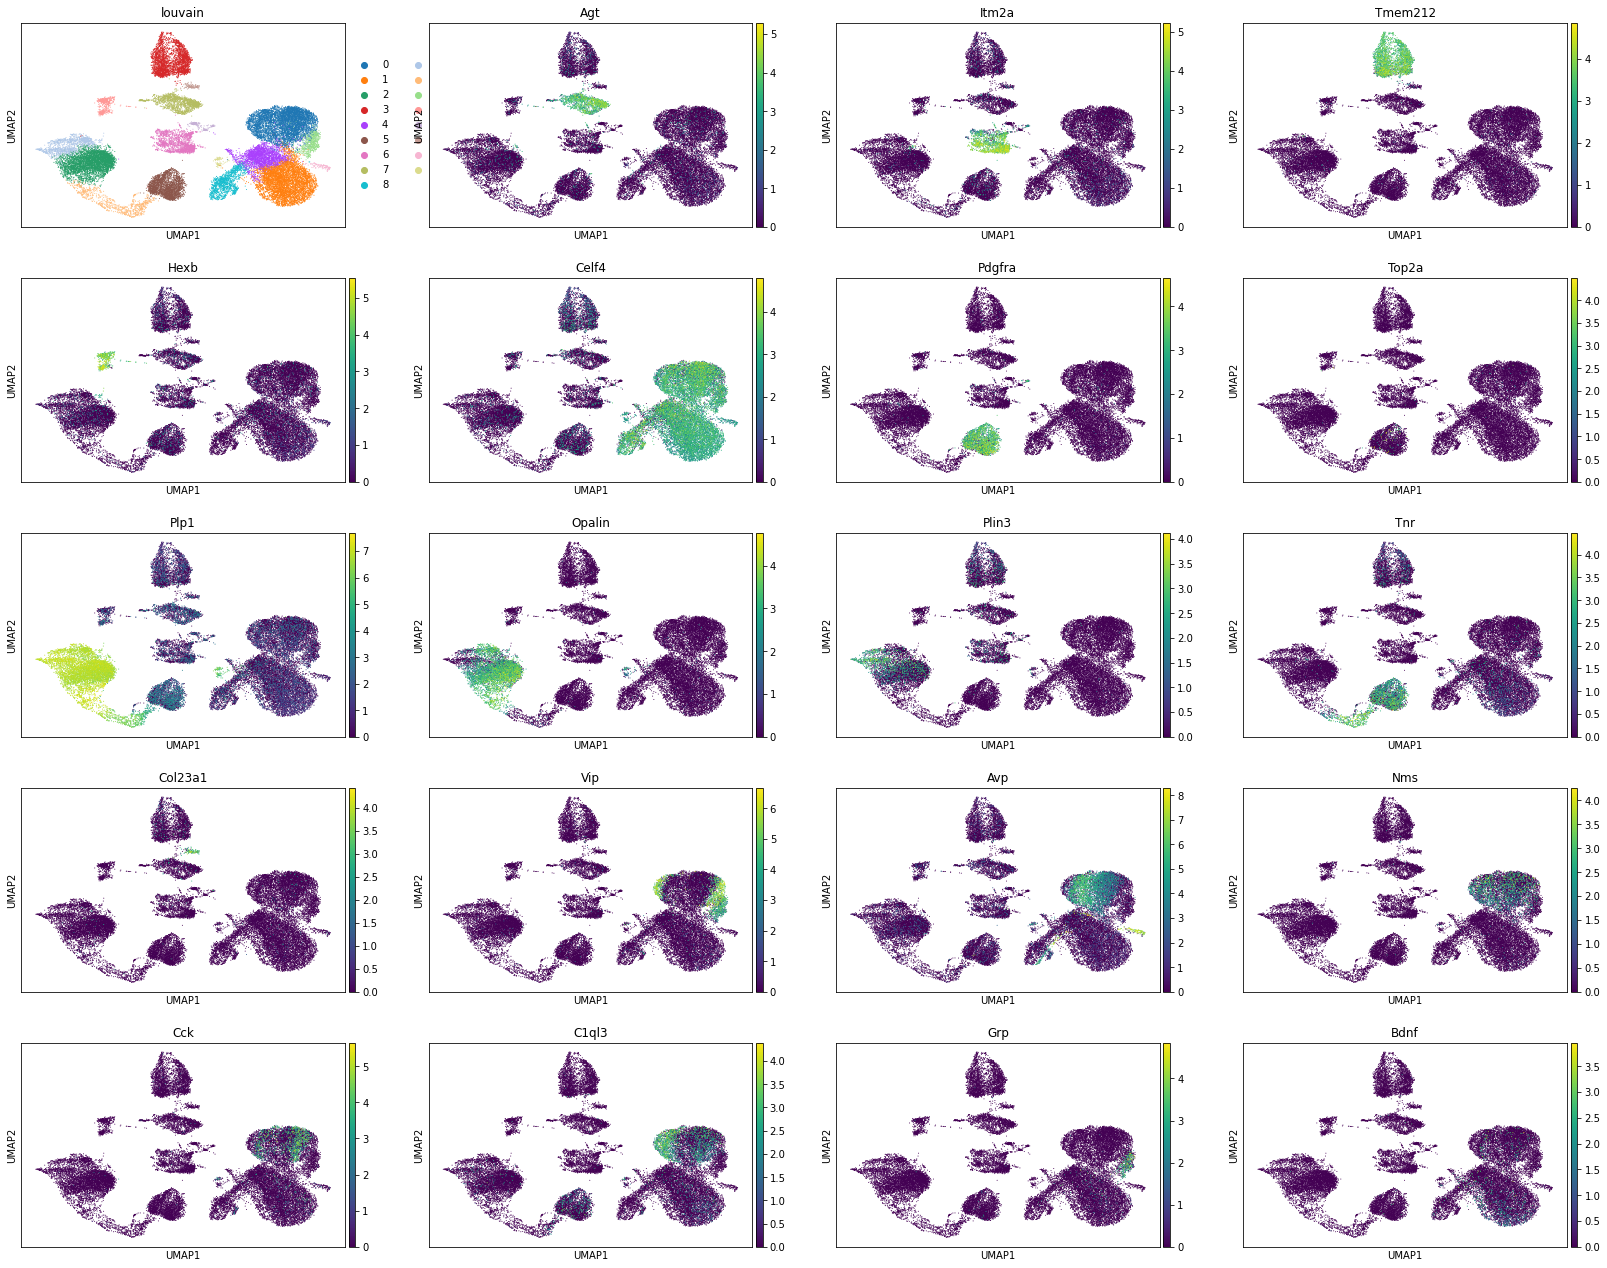

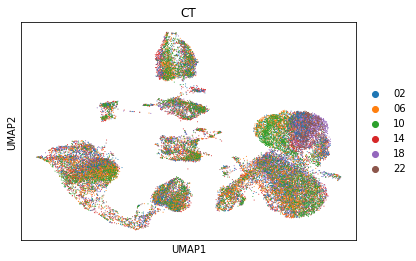

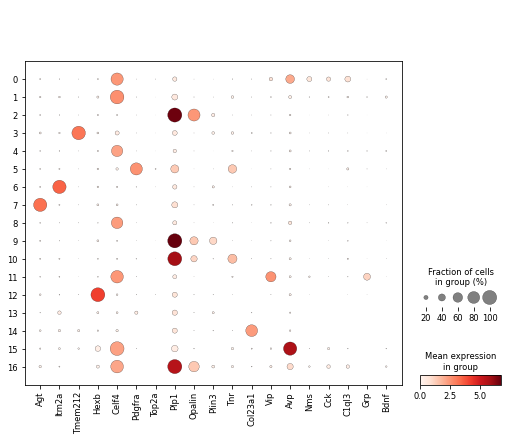

In [7]:


sc.tl.louvain(adata, resolution=0.7)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain' , title=("UMAP painted by louvain"))
marker_genes = ['Agt', 'Itm2a','Tmem212','Hexb','Celf4','Pdgfra','Top2a','Plp1','Opalin','Plin3','Tnr','Col23a1','Vip','Avp','Nms','Cck','C1ql3','Grp','Bdnf']
sc.pl.umap(adata, color=['louvain']+marker_genes)
sc.pl.umap(adata, color=['CT'])
orig_adata = adata.copy()
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

In [10]:

new_cluster_names = [
    'SCN Neurons', 'Neurons2' ,'Oligodendrocytes1' ,'Ependymal','Neurons3','NG2',
    'Endothelial', 
    'Astrocytes', 'Neurons4',
    'Oligodendrocytes2','Oligodendrocytes3','Neurons5',
    'Microglia' , 'not_real','Tanycytes','Neurons6' , 'Neurons7']
adata.rename_categories('louvain', new_cluster_names)

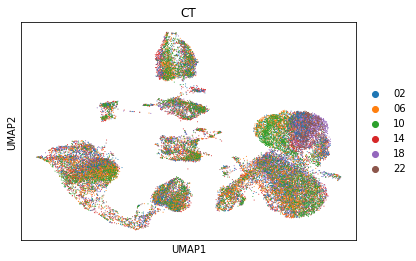

In [11]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CT'])
orig_adata = adata.copy()

In [12]:
adata1 = adata[adata.obs['louvain'].isin(['Astrocytes'])]
adata1

View of AnnData object with n_obs × n_vars = 1447 × 20299
    obs: 'CT', 'ST', 'day', 'batch', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors', 'CT_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
adata1 = pre_processes_for_cyclum(adata1,r_genes,type_genes)
cluster='Astrocytes'
model = cyclum.tuning.CyclumAutoTune(adata1.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model.train(adata1.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime = model.predict_pseudotime(adata1.X)
circular_comp = model.get_circular_component(pseudotime)

Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...


2022-09-30 08:38:59.110970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch: 100/500, loss:  0.1999, time elapsed:  12.94s, time left:  51.74s
epoch: 200/500, loss:  0.1850, time elapsed:  27.08s, time left:  40.62s
epoch: 300/500, loss:  0.1791, time elapsed:  42.58s, time left:  28.39s
epoch: 400/500, loss:  0.1772, time elapsed:  63.41s, time left:  15.85s
epoch: 500/500, loss:  0.1754, time elapsed:  83.66s, time left:  0.00s
[0.17544648051261902]
[0.24754117, 0.24447025, 0.24271084, 0.24113142, 0.24005233, 0.23900415, 0.23807652, 0.2371884, 0.23634134, 0.23551139, 0.23470844, 0.23392144]
    1 linear dimensions...
epoch: 100/500, loss:  0.1724, time elapsed:  25.05s, time left:  100.19s
epoch: 200/500, loss:  0.1711, time elapsed:  43.78s, time left:  65.68s
epoch: 300/500, loss:  0.1709, time elapsed:  62.84s, time left:  41.89s
epoch: 400/500, loss:  0.1709, time elapsed:  84.20s, time left:  21.05s
epoch: 500/500, loss:  0.1709, time elapsed:  98.10s, time left:  0.00s
[0.17544648051261902, 0.17086060345172882]
[0.24754117, 0.24447025, 0.24271084

In [14]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
flat_embedding = flat_embedding[:,0]
sort = np.argsort(flat_embedding)
bdata = adata1.copy()
bdata = bdata[sort,:]
adata_circular = bdata.copy()
adata_circular.X = circular_comp


In [15]:
adata4 = orig_adata[orig_adata.obs['louvain'].isin(['Microglia'])]
cluster='Microglia'
adata4 = pre_processes_for_cyclum(adata4,r_genes,type_genes)
model4 = cyclum.tuning.CyclumAutoTune(adata4.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model4.train(adata4.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime4 = model4.predict_pseudotime(adata4.X)
circular_comp4 = model4.get_circular_component(pseudotime4)


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.2720, time elapsed:  7.28s, time left:  29.11s
epoch: 200/500, loss:  0.2561, time elapsed:  15.17s, time left:  22.75s
epoch: 300/500, loss:  0.2460, time elapsed:  24.64s, time left:  16.43s
epoch: 400/500, loss:  0.2381, time elapsed:  30.81s, time left:  7.70s
epoch: 500/500, loss:  0.2316, time elapsed:  36.22s, time left:  0.00s
[0.23160918056964874]
[0.29768705, 0.29469907, 0.2922263, 0.29032618, 0.2886084, 0.2871166, 0.28570586, 0.2843497, 0.28300244, 0.2816928, 0.2804246, 0.27916333]
    1 linear dimensions...
epoch: 100/500, loss:  0.2137, time elapsed:  4.74s, time left:  18.95s
epoch: 200/500, loss:  0.2105, time elapsed:  11.34s, time left:  17.01s
epoch: 300/500, loss:  0.2090, time elapsed:  16.00s, time left:  10.67s
epoch: 400/500, loss:  0.2083, time elapsed:  20.19s, time left:  5.05s
epoch: 500/500, loss:  0.2080, time elapsed

In [16]:
flat_embedding4 = (pseudotime4 % (2 * np.pi)) / 2
flat_embedding4 = flat_embedding4[:,0]
sort4 = np.argsort(flat_embedding4)
bdata4 = adata4.copy()
bdata4 = bdata4[sort4,:]
adata_circular4 = bdata4.copy()
adata_circular4.X = circular_comp4


In [17]:
def preproc_for_lr(adata,adata_micro,adata_astro):
    '''The workflow was applied for each cell type separately, this function merges the processed data'''
    cluster_list = [
        'Astrocytes',
        'Microglia']
    adata_raw = adata.copy()
    adata.X = adata.X *0
    adata_en = adata.copy()
    barcodes = []
    clusters = []
    adata.obs['cluster'] =1
    a = np.ones((10,10))
    for ob in adata_micro.obs_names:
            adata[ob,adata_micro[ob,:].var_names].X = adata_raw[ob,adata_micro[ob,:].var_names].X
            adata_en[ob,adata_micro[ob,:].var_names].X = adata_micro[ob,adata_micro[ob,:].var_names].X
            #https://stackoverflow.com/questions/63272201/how-to-add-an-observation-category-on-scanpy-based-on-another-observation
    for ob in adata_astro.obs_names:
            adata[ob,adata_astro[ob,:].var_names].X = adata_raw[ob,adata_astro[ob,:].var_names].X
            adata_en[ob,adata_astro[ob,:].var_names].X = adata_astro[ob,adata_astro[ob,:].var_names].X
            #https://stackoverflow.com/questions/63272201/how-to-add-an-observation-category-on-scanpy-based-on-another-observation
    return adata , adata_en



In [18]:
cluster_list = [
        'Astrocytes',
        'Microglia']
subset_of_adata = adata[adata.obs['louvain'].isin(cluster_list)]
subset_of_adata = subset_of_adata.copy()
pdata, pdata_en = preproc_for_lr(subset_of_adata, adata_circular4,adata_circular) 


In [21]:
pdata_en2 = pdata_en.copy()

In [23]:
sc.pp.normalize_per_cell(pdata_en, counts_per_cell_after=1e4)
sc.pp.log1p(pdata_en)
pdata_en_norm = pdata_en


In [22]:
pdata_en.X = np.clip(np.array(pdata_en.X),0 , np.inf)

In [8]:
def find_diff_matrix(cluster1,cluster2,comm_array_raw,comm_array_en):
    '''Find the interactions whose score increased at least two-fold following scPrisma's enhancement (and statistically significant)'''
    df_raw , df_en = find_lr_df(cluster1,cluster2,comm_array_raw,comm_array_en)
    df_en_sorted = retain_high_scores_en(df_raw , df_en)
    return df_en_sorted

def find_lr_df(cluster1,cluster2,comm_array_raw,comm_array_en):
    '''Transfer cellphonedb output to dataframe'''
    sf = ((((comm_array_raw['means'])[cluster1])[cluster2]))
    sf_p = ((((comm_array_raw['pvalues'])[cluster1])[cluster2]))
    df1 = pd.DataFrame(data=sf.index, columns=['source'])
    df2 = pd.DataFrame(data=sf.values, columns=['values'])
    df3 = pd.DataFrame(data=sf_p.values, columns=['pvalues'])
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df[['source', 'target']] = pd.DataFrame(df['source'].tolist(), index=df.index)
    df = df.dropna()
    df_raw = df
    sf = ((((comm_array_en['means'])[cluster1])[cluster2]))
    sf_p = ((((comm_array_en['pvalues'])[cluster1])[cluster2]))
    df1 = pd.DataFrame(data=sf.index, columns=['source'])
    df2 = pd.DataFrame(data=sf.values, columns=['values'])
    df3 = pd.DataFrame(data=sf_p.values, columns=['pvalues'])
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df[['source', 'target']] = pd.DataFrame(df['source'].tolist(), index=df.index)
    df = df.dropna()
    df_en = df
    return df_raw , df_en

def retain_high_scores_en(df_raw , df_en):
    '''Retain only positive scores which increased at least two-fold following scPrisma's enhancement'''
    df_en = df_en[(df_en['values'] > 0) ]
    df_en = df_en.sort_values(by='values', ascending=False)
    for index, row in df_en.iterrows():
        df_raw_tmp = df_raw[(df_raw['source'] ==row['source']) ]
        if len(df_raw_tmp.index)==0:
            continue
        df_raw_tmp = df_raw_tmp[( df_raw_tmp['target']==row['target'])]
        if len(df_raw_tmp.index)==0:
            continue
        if row['values'] <  2*float(df_raw_tmp['values']):#2* float(df_raw_tmp['values']):
            df_en.drop(index, axis=0, inplace=True)
    return df_en

def count_ligand_receptor(df,ligands_list,receptors_list):
    '''Count number of interactions that contains genes from ligands/receptor lists'''
    count_ligand=0
    for ligand in ligands_list:
        count_ligand+=df[df['source']==ligand].shape[0]
    count_receptor=0
    for receptor in receptors_list:
        count_receptor+=df[df['target']==receptor].shape[0]
    return count_ligand , count_receptor



In [ ]:
pdata.write("SCN/pdata.h5ad")

In [ ]:
pdata.write("SCN/pdata.h5ad")
pdata_en.write("SCN/pdata_en.h5ad")

In [4]:
pdata = sc.read("SCN/pdata.h5ad")
pdata_en = sc.read("SCN/pdata_en.h5ad")
pdata_en_norm = pdata_en

In [24]:
pdata_02 = (pdata[pdata.obs['CT'].isin(['02'])])
pdata_en_02 = (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['02'])])
res_raw_02 = sq.gr.ligrec(
        pdata_02,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )
res_en_02 = sq.gr.ligrec(
        pdata_en_02,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_06 = (pdata[pdata.obs['CT'].isin(['06'])])
pdata_en_06= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['06'])])
res_raw_06 = sq.gr.ligrec(
        pdata_06,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_06 = sq.gr.ligrec(
        pdata_en_06,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_10 = (pdata[pdata.obs['CT'].isin(['10'])])
pdata_en_10= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['10'])])
res_raw_10 = sq.gr.ligrec(
        pdata_10,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_10 = sq.gr.ligrec(
        pdata_en_10,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_14 = (pdata[pdata.obs['CT'].isin(['14'])])
pdata_en_14= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['14'])])
res_raw_14 = sq.gr.ligrec(
        pdata_14,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_14 = sq.gr.ligrec(
        pdata_en_14,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_18 = (pdata[pdata.obs['CT'].isin(['18'])])
pdata_en_18= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['18'])])
res_raw_18 = sq.gr.ligrec(
        pdata_18,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_18 = sq.gr.ligrec(
        pdata_en_18,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )


pdata_22 = (pdata[pdata.obs['CT'].isin(['22'])])
pdata_en_22= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['22'])])
res_raw_22 = sq.gr.ligrec(
        pdata_22,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_22 = sq.gr.ligrec(
        pdata_en_22,
        n_perms=1000,
        cluster_key="louvain",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )
def get_lr_score(res, cell_type_source,cell_type_target,ligand, receptor):
    try:
        return ((((res['means'])[cell_type_source])[cell_type_target])[ligand])[receptor]
    except:
        return 0
pdata_02.write("adata_for_lr_raw_02.h5ad")
pdata_en_02.write("adata_for_lr_cyclum_02.h5ad")
pdata_06.write("adata_for_lr_raw_06.h5ad")
pdata_en_06.write("adata_for_lr_cyclum_06.h5ad")
pdata_10.write("adata_for_lr_raw_10.h5ad")
pdata_en_10.write("adata_for_lr_cyclum_10.h5ad")
pdata_14.write("adata_for_lr_raw_14.h5ad")
pdata_en_14.write("adata_for_lr_cyclum_14.h5ad")
pdata_18.write("adata_for_lr_raw_18.h5ad")
pdata_en_18.write("adata_for_lr_cyclum_18.h5ad")
pdata_22.write("adata_for_lr_raw_22.h5ad")
pdata_en_22.write("adata_for_lr_cyclum_22.h5ad")

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/squidpy/gr/_ligrec.py:374: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self._filtered_data["clusters"] = self._adata.obs.copy()[cluster_key].astype("string").astype("category").values


  0%|          | 0/1000 [00:00<?, ?permutation/s]

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/squidpy/gr/_ligrec.py:374: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self._filtered_data["clusters"] = self._adata.obs.copy()[cluster_key].astype("string").astype("category").values


  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [39]:
cluster1= 'Astrocytes'
cluster2 = 'Microglia'
ligand = 'Avp'
receptor = 'Plau'

In [30]:
print(get_lr_score(res_raw_14, cluster1,cluster2,(ligand).upper(), (receptor).upper()))
print("02: " + str(get_lr_score(res_en_02, cluster1,cluster2,(ligand).upper(), (receptor).upper())))
print("06: " + str(get_lr_score(res_en_06, cluster1,cluster2,(ligand).upper(), (receptor).upper())))
print("10: " + str(get_lr_score(res_en_10, cluster1,cluster2,(ligand).upper(), (receptor).upper())))
print("14: " + str(get_lr_score(res_en_14, cluster1,cluster2,(ligand).upper(), (receptor).upper())))
print("18: " + str(get_lr_score(res_en_18, cluster1,cluster2,(ligand).upper(), (receptor).upper())))
print("22: " + str(get_lr_score(res_en_22, cluster1,cluster2,(ligand).upper(), (receptor).upper())))


0.12268805807580899
02: 1.4286520510093896
06: 1.5245443479503904
10: 1.5243425541341984
14: 1.3948193486077192
18: 1.5051162307594625
22: 1.334473839283151


In [37]:
def plt_mean_gene_c(adata, cluster, gene, up_lim=0.6, down_lim=-0.05):
    adata_raw = adata.copy()
    adata_raw = adata_raw[adata_raw.obs['louvain'].isin([cluster])]
    ct_list = ['02', '06', '10', '14', '18', '22']
    e_array = np.zeros(6)
    for i, ct in enumerate(ct_list):
        adata_nr = (adata_raw[adata_raw.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
    plt.figure()
    plt.subplot(211)
    plt.plot(ct_list, e_array, 'k')
    plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
    plt.ylim([down_lim, up_lim])
    plt.title("Mean "+ gene + " expression on raw " + cluster + " data")
    plt.ylabel("Gene expression", fontsize=14)
    plt.xlabel("Circadian time" , fontsize=14)
    plt.show()
    pass


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  if sys.path[0] == '':


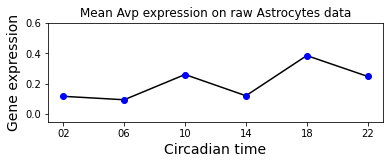

In [34]:
plt_mean_gene_c(pdata,'Astrocytes','Avp')

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  if sys.path[0] == '':


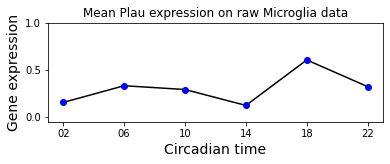

In [36]:
plt_mean_gene_c(pdata,'Microglia','Plau' , up_lim=1)

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


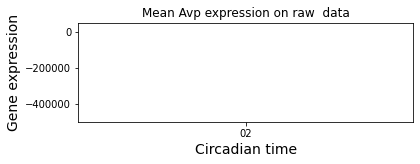